# AUTO ENCODERS

Epoch 1/50, Train Loss: 0.7196, Val Loss: 0.3554
Epoch 2/50, Train Loss: 0.4684, Val Loss: 0.2479
Epoch 3/50, Train Loss: 0.3573, Val Loss: 0.1817
Epoch 4/50, Train Loss: 0.2838, Val Loss: 0.1514
Epoch 5/50, Train Loss: 0.2368, Val Loss: 0.1324
Epoch 6/50, Train Loss: 0.1968, Val Loss: 0.1232
Epoch 7/50, Train Loss: 0.1661, Val Loss: 0.1154
Epoch 8/50, Train Loss: 0.1416, Val Loss: 0.1071
Epoch 9/50, Train Loss: 0.1265, Val Loss: 0.0890
Epoch 10/50, Train Loss: 0.1065, Val Loss: 0.0938
Epoch 11/50, Train Loss: 0.1056, Val Loss: 0.0804
Epoch 12/50, Train Loss: 0.0939, Val Loss: 0.0840
Epoch 13/50, Train Loss: 0.0924, Val Loss: 0.0925
Epoch 14/50, Train Loss: 0.1017, Val Loss: 0.0689
Epoch 15/50, Train Loss: 0.0802, Val Loss: 0.0683
Epoch 16/50, Train Loss: 0.0693, Val Loss: 0.0654
Epoch 17/50, Train Loss: 0.0667, Val Loss: 0.0639
Epoch 18/50, Train Loss: 0.0638, Val Loss: 0.0672
Epoch 19/50, Train Loss: 0.0716, Val Loss: 0.0592
Epoch 20/50, Train Loss: 0.0641, Val Loss: 0.0658
Epoch 21/

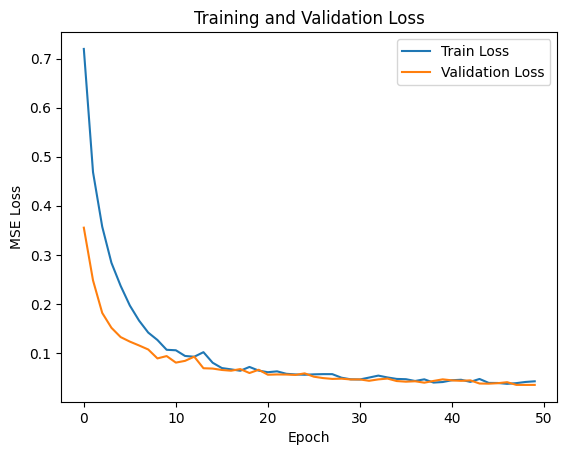

Overall Reconstruction MSE: 0.0353


In [56]:


# Load dataset
df = pd.read_csv('final_data.csv')

# Separate features and scale
features = df.drop(columns=['Food Name'])
scaler = StandardScaler()
X = scaler.fit_transform(features.values)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)

# Create dataset and split
dataset = TensorDataset(X_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Define autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim=31, latent_dim=16):  # Try 8 or 16
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Initialize model
input_dim = X.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        data = batch[0]
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0]
            output = model(data)
            loss = criterion(output, data)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate model
model.eval()
with torch.no_grad():
    reconstructed = model(X_tensor)
    mse = mean_squared_error(X_tensor.numpy(), reconstructed.numpy())
    print(f"Overall Reconstruction MSE: {mse:.4f}")

# Plot coefficient matrix (weights of first encoder layer)
weights = model.encoder[0].weight.data.numpy()

# plt.figure(figsize=(12, 8))
# sns.heatmap(weights, cmap='coolwarm', xticklabels=features.columns, yticklabels=[f"Enc_{i}" for i in range(weights.shape[0])])
# plt.title('Encoder First Layer Weights (Coefficient Matrix)')
# plt.xlabel('Input Features')
# plt.ylabel('Hidden Units')
# plt.show()


[KMeans] Silhouette Score: 0.2242
[KMeans] Davies-Bouldin Score: 1.9031
[DBSCAN] Silhouette Score: -0.0640
[DBSCAN] Davies-Bouldin Score: 0.8369

Top 5 similar foods to 'APPLEBEE'S, 9 oz house sirloin steak' (KMeans):
['Restaurant, family style, sirloin steak'
 'Sausage, turkey, fresh, cooked' 'CRACKER BARREL, grilled sirloin steak'
 'Sausage, turkey, fresh, raw'
 "T.G.I. FRIDAY'S, classic sirloin steak (10 oz)"]

Top 5 similar foods to 'APPLEBEE'S, 9 oz house sirloin steak' (DBSCAN):
['Restaurant, family style, sirloin steak'
 'Sausage, turkey, fresh, cooked' 'CRACKER BARREL, grilled sirloin steak'
 'Sausage, turkey, fresh, raw'
 "T.G.I. FRIDAY'S, classic sirloin steak (10 oz)"]


In [59]:
from sklearn.metrics import mean_absolute_error, pairwise_distances

def evaluate_model(model, data_tensor, has_labels=False, food_labels=None):
    model.eval()
    with torch.no_grad():
        reconstructed = model(data_tensor)

    # Convert to numpy
    original = data_tensor.cpu().numpy()
    recon = reconstructed.cpu().numpy()

    # Evaluation metrics
    mse = mean_squared_error(original, recon)
    mae = mean_absolute_error(original, recon)
    cos_sim = 1 - pairwise_distances(original, recon, metric='cosine').mean()

    silhouette = None
    if has_labels and food_labels is not None:
        latent = model.encoder(data_tensor).cpu().numpy()
        if len(food_labels) == len(latent):
            silhouette = silhouette_score(latent, food_labels)
        else:
            print("⚠️ Warning: Mismatch between labels and data size. Skipping silhouette score.")

    return {
        'MSE': mse,
        'MAE': mae,
        'Cosine_Similarity': cos_sim,
        'Silhouette_Score': silhouette
    }


In [60]:
metrics = evaluate_model(model, X_tensor)
print(metrics)


{'MSE': 0.013123933225870132, 'MAE': 0.0495377853512764, 'Cosine_Similarity': np.float32(0.009958446), 'Silhouette_Score': None}


In [62]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return reconstruction


# 3. Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        noisy = x + 0.1 * torch.randn_like(x)
        z = self.encoder(noisy)
        return self.decoder(z)





def evaluate_model(model, loader, input_dim, device='cpu'):
    model.eval()
    mse, mae, cos_sim = 0, 0, 0
    count = 0
    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)
            if isinstance(model, SiameseNetwork):
                x1 = x[:len(x)//2]
                x2 = x[len(x)//2:]
                _ = model(x1, x2)
                continue  # Evaluation is similarity-based for Siamese
            
            else:
                out = model(x)
            mse += F.mse_loss(out, x).item()
            mae += F.l1_loss(out, x).item()
            cos_sim += F.cosine_similarity(out, x).mean().item()
            count += 1
    return mse / count, mae / count, cos_sim / count


In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Load your data
df = pd.read_csv('final_data.csv')
features = df.drop(columns=['Food Name'])
scaler = StandardScaler()
X = scaler.fit_transform(features)
X_tensor = torch.FloatTensor(X)

# Train/Val/Test split
train, test = train_test_split(X_tensor, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)
train_loader = DataLoader(TensorDataset(train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(val), batch_size=64)
test_loader = DataLoader(TensorDataset(test), batch_size=64)

input_dim = X_tensor.shape[1]


In [29]:
def train_model(model, train_loader, val_loader, input_dim, device='cpu', epochs=100, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()
          
           
            out = model(x)
            loss = F.mse_loss(out, x)
            loss.backward()
            optimizer.step()

        # Evaluation on validation set
        val_mse, val_mae, val_cos = evaluate_model(model, val_loader, input_dim, device)
        print(f"[{epoch+1:3d}/100] Val MSE: {val_mse:.4f} | MAE: {val_mae:.4f} | Cosine: {val_cos:.4f}")

        if val_mse < best_val_loss:
            best_val_loss = val_mse
            torch.save(model.state_dict(), f"{type(model).__name__}_best.pth")


In [31]:
def evaluate_model(model, data_loader, input_dim, device='cpu'):
    model.eval()
    mse, mae, cosine = 0.0, 0.0, 0.0
    n = 0
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
           
          
            out = model(x)

            mse += F.mse_loss(out, x, reduction='sum').item()
            mae += F.l1_loss(out, x, reduction='sum').item()
            cosine += F.cosine_similarity(out, x, dim=1).sum().item()
            n += x.size(0)

    return mse / n, mae / n, cosine / n


In [43]:
model = DenoisingAutoencoder(input_dim=input_dim)
train_model(model, train_loader, val_loader, input_dim, device=device, epochs=100, lr=1e-3)

test_mse, test_mae, test_cos = evaluate_model(model, test_loader, input_dim, device)
print(f"\n🧪 Final Test Results for {type(model).__name__}:")
print(f"Test MSE: {test_mse:.4f} | MAE: {test_mae:.4f} | Cosine Similarity: {test_cos:.4f}")


[  1/100] Val MSE: 9.1037 | MAE: 8.7699 | Cosine: 0.8543
[  2/100] Val MSE: 5.4638 | MAE: 7.3091 | Cosine: 0.9087
[  3/100] Val MSE: 3.1484 | MAE: 5.7629 | Cosine: 0.9420
[  4/100] Val MSE: 2.2798 | MAE: 5.0305 | Cosine: 0.9565
[  5/100] Val MSE: 1.6490 | MAE: 4.4764 | Cosine: 0.9658
[  6/100] Val MSE: 1.4745 | MAE: 4.3512 | Cosine: 0.9695
[  7/100] Val MSE: 1.1433 | MAE: 3.9762 | Cosine: 0.9744
[  8/100] Val MSE: 0.9706 | MAE: 3.7497 | Cosine: 0.9773
[  9/100] Val MSE: 0.7648 | MAE: 3.3652 | Cosine: 0.9815
[ 10/100] Val MSE: 0.8768 | MAE: 3.5661 | Cosine: 0.9802
[ 11/100] Val MSE: 0.7134 | MAE: 3.2687 | Cosine: 0.9830
[ 12/100] Val MSE: 0.6215 | MAE: 3.1580 | Cosine: 0.9840
[ 13/100] Val MSE: 0.6066 | MAE: 3.0569 | Cosine: 0.9851
[ 14/100] Val MSE: 0.5736 | MAE: 3.0352 | Cosine: 0.9853
[ 15/100] Val MSE: 0.5595 | MAE: 3.0038 | Cosine: 0.9855
[ 16/100] Val MSE: 0.5745 | MAE: 2.9770 | Cosine: 0.9861
[ 17/100] Val MSE: 0.6652 | MAE: 3.2560 | Cosine: 0.9840
[ 18/100] Val MSE: 0.6293 | MAE

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

# Load dataset
df = pd.read_csv('final_csv.csv')
features = df.drop(columns=['Food Name'])
scaler = StandardScaler()
X = scaler.fit_transform(features.values)
X_tensor = torch.tensor(X, dtype=torch.float32)

# Define weights for ALL 30 nutrients (example values - customize these!)
nutrient_weights = torch.tensor([
    2.0,   # Protein (G)
    0.5,   # Carbohydrate, by difference (G)
    0.1,   # Sugars, Total (G) 
    1.8,   # Fiber, total dietary (G)
    0.3,   # Total lipid (fat) (G)
    0.0,   # Energy (KCAL) - typically not weighted
    0.0,   # Energy (kJ) - typically not weighted
    0.0,   # Water (G) - typically not weighted
    1.0,   # Vitamin A, IU (IU)
    1.0,   # Vitamin A, RAE (UG)
    1.2,   # Vitamin B-12 (UG)
    1.2,   # Vitamin B-12, added (UG)
    1.1,   # Vitamin B-6 (MG)
    1.3,   # Vitamin C (MG)
    1.5,   # Vitamin D (UG)
    1.5,   # Vitamin D (IU)
    1.0,   # Vitamin E (MG)
    1.0,   # Vitamin E, added (MG)
    1.0,   # Vitamin K (UG)
    1.1,   # Thiamin (MG)
    1.1,   # Riboflavin (MG)
    1.0,   # Calcium (MG)
    1.2,   # Iron (MG)
    1.0,   # Magnesium (MG)
    1.0,   # Phosphorus (MG)
    1.0,   # Potassium (MG)
    0.2,   # Sodium (MG) - lower weight (less is better)
    1.0,   # Zinc (MG)
    1.0,   # Selenium (UG)
    1.0,   # Copper (MG)
    1.0    # Manganese (MG)
], dtype=torch.float32)

assert len(nutrient_weights) == X.shape[1], "Weights must match number of features!"

# Split data
train_data, test_data = train_test_split(X_tensor, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_loader = DataLoader(TensorDataset(train_data), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(val_data), batch_size=64)
test_loader = DataLoader(TensorDataset(test_data), batch_size=64)

# Rest of your VAE code remains exactly the same...
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Training loop (unchanged)
model = VAE(input_dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

best_val_loss = float('inf')
for epoch in range(100):
    model.train()
    train_loss = 0
    for batch in train_loader:
        data = batch[0]
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar, nutrient_weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation (unchanged)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0]
            recon, mu, logvar = model(data)
            val_loss += vae_loss(recon, data, mu, logvar, nutrient_weights).item()
    val_loss /= len(val_loader)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

# Recommendation function (unchanged)
def recommend_similar(food_index, top_k=5):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    with torch.no_grad():
        latent_vectors = []
        for batch in test_loader:
            data = batch[0]
            h = model.encoder(data)
            mu = model.fc_mu(h)
            latent_vectors.append(mu)
        latent_vectors = torch.cat(latent_vectors)
    
    target = latent_vectors[food_index].numpy()
    sim = 1 - pairwise_distances(latent_vectors.numpy(), [target], metric='cosine').flatten()
    top_indices = sim.argsort()[-top_k-1:-1][::-1]
    return df.iloc[top_indices]

# Test
# print(recommend_similar(0))  # Recommend foods similar to first test item

In [10]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_score, pairwise_distances

def evaluate_model(model, test_loader, has_labels=False, food_labels=None):
    model.eval()
    reconstructions, latent_vecs, originals = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            data = batch[0]
            recon, mu, _ = model(data)
            reconstructions.append(recon)
            latent_vecs.append(mu)
            originals.append(data)

    # Stack tensors
    X_test = torch.cat(originals).cpu().numpy()
    X_recon = torch.cat(reconstructions).cpu().numpy()
    latent = torch.cat(latent_vecs).cpu().numpy()

    # Compute reconstruction metrics
    mse = mean_squared_error(X_test, X_recon)
    mae = mean_absolute_error(X_test, X_recon)
    cos_sim = 1 - pairwise_distances(X_test, X_recon, metric='cosine').mean()

    # Optional clustering metric in latent space
    silhouette = None
    if has_labels and food_labels is not None:
        if len(food_labels) == len(latent):
            silhouette = silhouette_score(latent, food_labels)
        else:
            print("⚠️ Warning: Mismatch between food_labels and test data size. Skipping silhouette score.")

    return {
        'MSE': mse,
        'MAE': mae,
        'Cosine_Similarity': cos_sim,
        'Silhouette_Score': silhouette
    }


In [11]:
metrics = evaluate_model(model, test_loader)
print(metrics)


{'MSE': 1.0209800004959106, 'MAE': 0.5294637084007263, 'Cosine_Similarity': np.float32(-0.011639833), 'Silhouette_Score': None}


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

with torch.no_grad():
    reconstructions, _, _ = model(X_test)
    mse = mean_squared_error(X_test.numpy(), reconstructions.numpy())
    mae = mean_absolute_error(X_test.numpy(), reconstructions.numpy())
    cos_sim = 1 - pairwise_distances(X_test.numpy(), reconstructions.numpy(), metric='cosine').mean()

NameError: name 'X_test' is not defined

In [2]:
# Get encoded representations for all foods
model.eval()
with torch.no_grad():
    encoded = model.encoder(X_tensor).numpy()


In [3]:
query_idx = 10  # Example: 10th food in the dataset
query_vector = encoded[query_idx]


In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute cosine similarity to all other foods
similarities = cosine_similarity([query_vector], encoded)[0]

# Get top 5 most similar (excluding the query food itself)
top_indices = similarities.argsort()[::-1][1:6]
recommended_foods = df.iloc[top_indices]


In [16]:
# Extract latent features from encoder
model.eval()
with torch.no_grad():
    latent_features = model.encoder(X_tensor)
latent_np = latent_features.numpy()


In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Choose number of clusters (tune this based on elbow method or domain knowledge)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_np)

# Add cluster labels to original DataFrame
df['Cluster'] = cluster_labels


NameError: name 'latent_np' is not defined

In [ ]:
# Silhouette Score
sil_score = silhouette_score(latent_np, cluster_labels)
print(f"Silhouette Score: {sil_score:.3f}")


Silhouette Score: 0.254


In [12]:
# Assume your dataset has these columns (customize as needed):
# 'Calories', 'Protein', 'Sugar', 'Fat', 'Fiber'

def compute_nutri_score(row):
    # Higher protein and fiber = good; lower sugar and fat = good
    return (
        -0.5 * row['Energy (KCAL)'] + 
          2.0 * row['Protein (G)'] - 
         1.5 * row['Sugars, Total (G)'] - 
         1.0 * row['Total lipid (fat) (G)'] + 
         2.0 * row['Fiber, total dietary (G)']
    )

df['Nutri Score'] = df.apply(compute_nutri_score, axis=1)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Encode all food items to latent space
model.eval()
with torch.no_grad():
    encoded = model.encoder(X_tensor).numpy()

# Step 2: Pick a query food index or name
query_idx = 10  # You can change this
query_vector = encoded[query_idx]
query_food = df.iloc[query_idx]

# Step 3: Compute cosine similarity and get top 5 recommendations
similarities = cosine_similarity([query_vector], encoded)[0]
top_indices = similarities.argsort()[::-1][1:6]  # Exclude the query itself
recommended_foods = df.iloc[top_indices]

# Step 4: Compare based on Nutri Score
print("🔹 Query Food:")
print(query_food[['Food Name', 'Nutri Score']])

print("\n🔸 Top 5 Recommendations:")
print(recommended_foods[['Food Name', 'Nutri Score']])

# Step 5: Visualize Nutri Scores
import matplotlib.pyplot as plt

labels = ['Query'] + [f"Rec {i+1}" for i in range(5)]
scores = [query_food['Nutri Score']] + recommended_foods['Nutri Score'].tolist()

plt.bar(labels, scores, color='mediumseagreen')
plt.ylabel('Nutri Score')
plt.title('Nutri Score Comparison: Query vs Recommendations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🔹 Query Food:
Food Name      APPLEBEE'S, mozzarella sticks
Nutri Score                        -0.054013
Name: 10, dtype: object

🔸 Top 5 Recommendations (Similar Nutri Score):
                                              Food Name  Nutri Score
3994                               Ham, chopped, canned    -0.054042
4250  Lamb, Australian, ground,  85% lean / 15% fat,...    -0.054123
1591  Beverages, Carob-flavor beverage mix, powder, ...    -0.054815
5342  Peaches, dehydrated (low-moisture), sulfured, ...    -0.054972
1227  Beef, rib, whole (ribs 6-12), separable lean a...    -0.056013


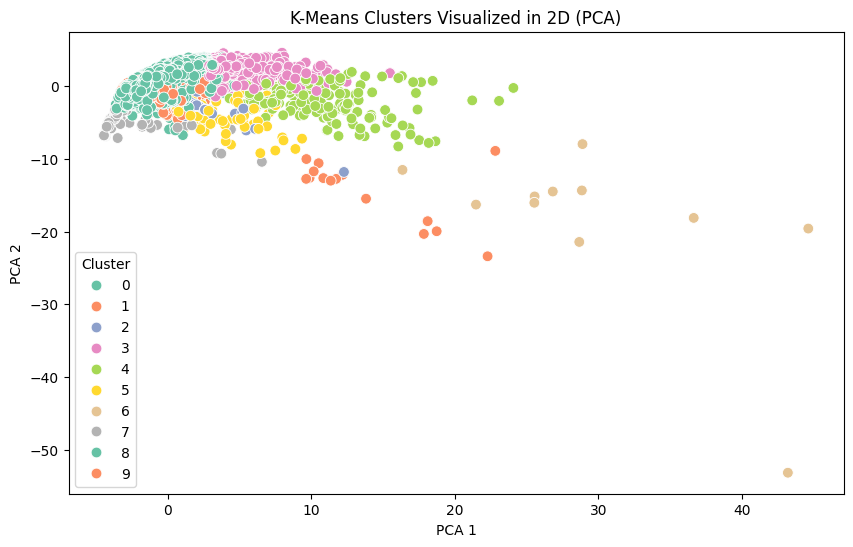

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_features = pca.fit_transform(latent_np)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=cluster_labels, palette='Set2', s=60)
plt.title('K-Means Clusters Visualized in 2D (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()


In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd

# Load and preprocess data
df = pd.read_csv('final_csv.csv')
X_raw = df.drop(columns=['Food Name'])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Apply K-Means
k = 10  # Number of clusters (can tune this)
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels back to DataFrame
df['Cluster'] = labels

# Evaluate clustering
sil_score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {sil_score:.3f}")


Silhouette Score: 0.191


In [21]:
if 'Nutri-Score' in df.columns:
    cluster_stats = df.groupby('Cluster')['Nutri-Score'].agg(['mean', 'std', 'count'])
    print("Nutri-Score Stats by Cluster:\n", cluster_stats)


In [22]:
def compute_nutri_score_custom(row):
    # Extract relevant fields
    energy = row['Energy (kJ)']
    sugars = row['Sugars, Total (G)']
    sodium = row['Sodium, Na (MG)']
    fiber = row['Fiber, total dietary (G)']
    protein = row['Protein (G)']

    # --- Negative points ---
    neg_points = 0

    thresholds_energy = [335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350]
    neg_points += sum(energy > t for t in thresholds_energy)

    thresholds_sugar = [4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45]
    neg_points += sum(sugars > t for t in thresholds_sugar)

    thresholds_sodium = [90, 180, 270, 360, 450, 540, 630, 720, 810, 900]
    neg_points += sum(sodium > t for t in thresholds_sodium)

    # --- Positive points ---
    pos_points = 0

    thresholds_fiber = [0.9, 1.9, 2.8, 3.7, 4.7]
    pos_points += sum(fiber > t for t in thresholds_fiber)

    thresholds_protein = [1.6, 3.2, 4.8, 6.4, 8]
    pos_points += sum(protein > t for t in thresholds_protein)

    score = neg_points - pos_points

    # Grade assignment
    if score <= -1:
        return 'A'
    elif score <= 2:
        return 'B'
    elif score <= 10:
        return 'C'
    elif score <= 18:
        return 'D'
    else:
        return 'E'


In [23]:
df['NutriScore'] = df.apply(compute_nutri_score_custom, axis=1)


In [24]:
# Assuming you have a 'Cluster' column from K-means
cluster_nutri_stats = df.groupby('Cluster')['NutriScore'].value_counts(normalize=True).unstack().fillna(0)
print(cluster_nutri_stats)


NutriScore         A         B
Cluster                       
0           0.722788  0.277212
1           0.998334  0.001666
2           0.456140  0.543860
3           0.988558  0.011442
4           0.963190  0.036810
5           0.956522  0.043478
6           0.970555  0.029445
7           1.000000  0.000000
8           1.000000  0.000000
9           0.514107  0.485893


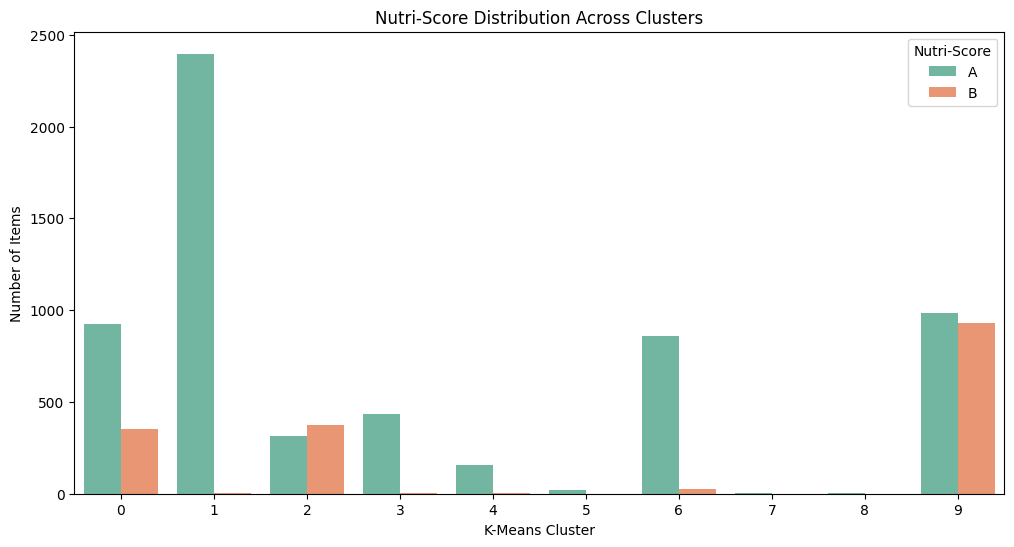

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Cluster', hue='NutriScore', palette='Set2')
plt.title('Nutri-Score Distribution Across Clusters')
plt.xlabel('K-Means Cluster')
plt.ylabel('Number of Items')
plt.legend(title='Nutri-Score')
plt.show()


In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(X_scaled)
inertia = kmeans.inertia_
print("Inertia (WSS):", inertia)


NameError: name 'K' is not defined

In [27]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(X_scaled, kmeans.labels_)
print("Silhouette Score:", sil_score)


Silhouette Score: 0.19061400263433687


In [28]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(X_scaled, kmeans.labels_)
print("Davies-Bouldin Index:", db_index)


Davies-Bouldin Index: 1.769528698818542


In [29]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(X_scaled, kmeans.labels_)
print("Calinski-Harabasz Score:", ch_score)


Calinski-Harabasz Score: 623.5938034004236


In [30]:
# Encode NutriScore to numbers (A=0, B=1, ..., E=4)
score_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df['NutriScore_encoded'] = df['NutriScore'].map(score_map)

# Calculate stats per cluster
nutri_variance = df.groupby('Cluster')['NutriScore_encoded'].std()
nutri_mean = df.groupby('Cluster')['NutriScore_encoded'].mean()

print("NutriScore Std Deviation per Cluster:\n", nutri_variance)
print("NutriScore Mean per Cluster:\n", nutri_mean)


NutriScore Std Deviation per Cluster:
 Cluster
0    0.447798
1    0.040791
2    0.498437
3    0.106474
4    0.188875
5    0.208514
6    0.169146
7    0.000000
8    0.000000
9    0.499932
Name: NutriScore_encoded, dtype: float64
NutriScore Mean per Cluster:
 Cluster
0    0.277212
1    0.001666
2    0.543860
3    0.011442
4    0.036810
5    0.043478
6    0.029445
7    0.000000
8    0.000000
9    0.485893
Name: NutriScore_encoded, dtype: float64


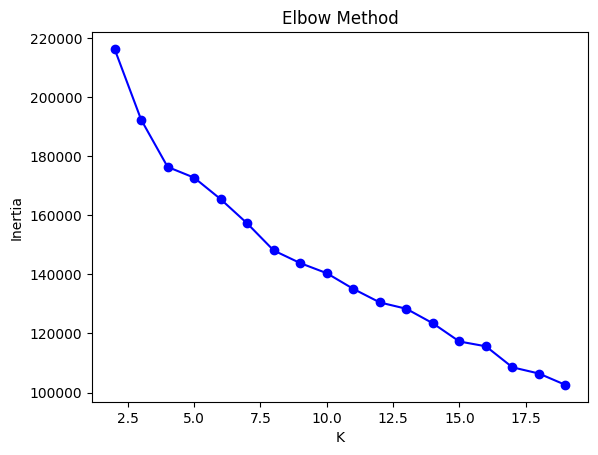

In [31]:
inertias = []
K_range = range(2, 20)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, 'bo-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


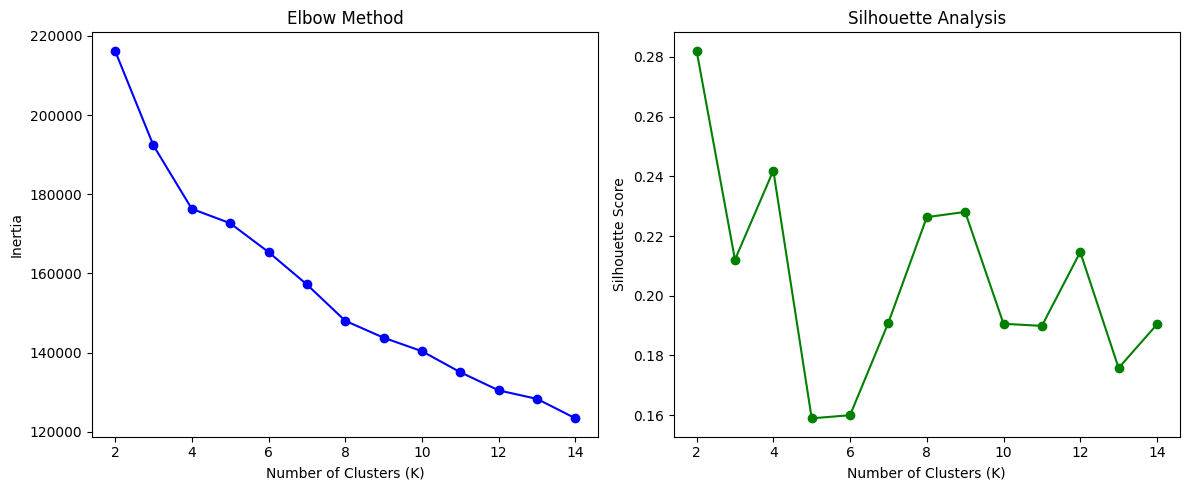

In [32]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load and preprocess
df = pd.read_csv('final_csv.csv')
X = df.drop(columns=['Food Name'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try different K values
inertias = []
silhouette_scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load your dataset
df = pd.read_csv('final_csv.csv')

# Drop 'Food Name' and scale the data
features = df.drop(columns=['Food Name'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Train KMeans with K=4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to original data
df['Cluster'] = cluster_labels

# Evaluate: Silhouette Score
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for K={k}: {sil_score:.4f}")

# Select only numeric columns for aggregation
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Evaluate: Nutritional stats within each cluster (mean and std for numeric features)
cluster_summary = df.groupby('Cluster')[numeric_cols].agg(['mean', 'std'])

# Print a compact summary
for i in range(k):
    print(f"\n🧪 Cluster {i} Summary:")
    print(cluster_summary.loc[i][['mean', 'std']].T.sort_index())

# (Optional) Save clustered data
df.to_csv('clustered_food_data.csv', index=False)


Silhouette Score for K=4: 0.2419

🧪 Cluster 0 Summary:


KeyError: "['mean' 'std'] not in index"

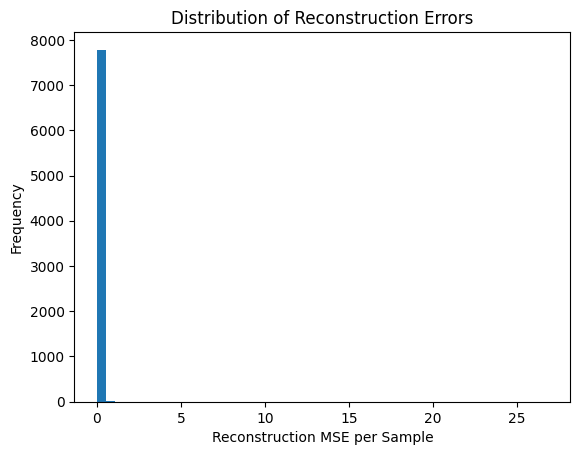

In [4]:
model.eval()
with torch.no_grad():
    recon = model(X_tensor)
    errors = ((X_tensor - recon) ** 2).mean(dim=1).numpy()

plt.hist(errors, bins=50)
plt.xlabel("Reconstruction MSE per Sample")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.show()


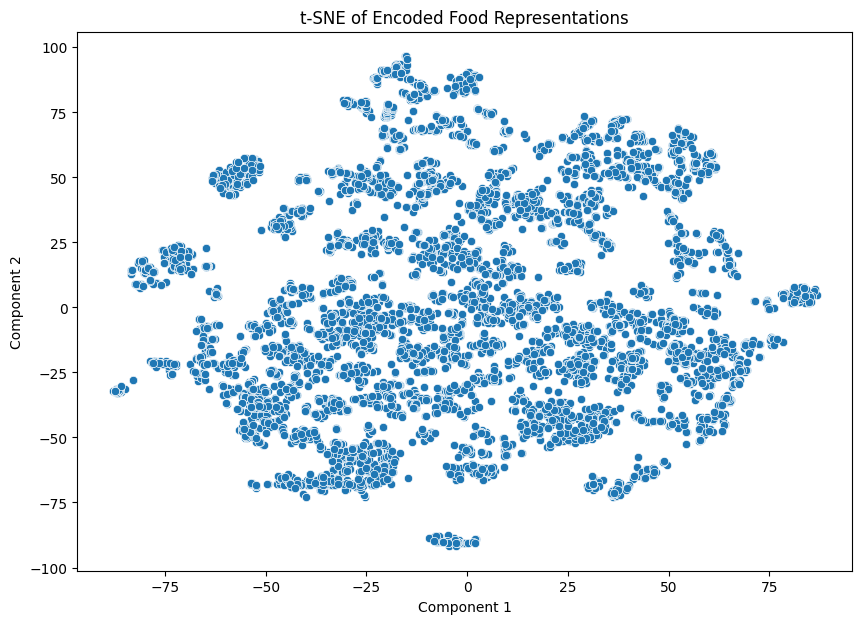

In [5]:
from sklearn.manifold import TSNE
import seaborn as sns

model.eval()
with torch.no_grad():
    encoded = model.encoder(X_tensor).numpy()

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(encoded)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1])
plt.title("t-SNE of Encoded Food Representations")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

food_names = df['Food Name'].tolist()
encoded_vecs = model.encoder(X_tensor).detach().numpy()
sim_matrix = cosine_similarity(encoded_vecs)

# Recommend similar items
def recommend(food_idx, top_k=5):
    sims = sim_matrix[food_idx]
    top_indices = np.argsort(sims)[::-1][1:top_k+1]
    print(f"Similar to '{food_names[food_idx]}':")
    for i in top_indices:
        print(f"  - {food_names[i]} (Similarity: {sims[i]:.2f})")

recommend(0)  # Change 0 to any food index


Similar to 'APPLEBEE'S, 9 oz house sirloin steak':
  - Restaurant, family style, sirloin steak (Similarity: 0.98)
  - CRACKER BARREL, grilled sirloin steak (Similarity: 0.95)
  - T.G.I. FRIDAY'S, classic sirloin steak (10 oz) (Similarity: 0.95)
  - Sausage, turkey, fresh, raw (Similarity: 0.95)
  - Sausage, turkey, fresh, cooked (Similarity: 0.95)


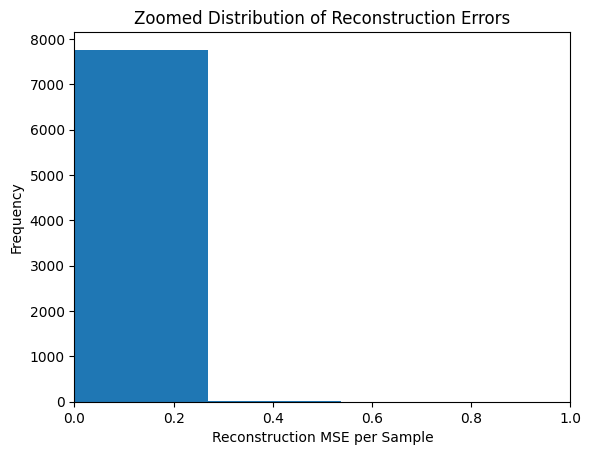

In [7]:
plt.hist(errors, bins=100)
plt.xlabel("Reconstruction MSE per Sample")
plt.ylabel("Frequency")
plt.title("Zoomed Distribution of Reconstruction Errors")
plt.xlim(0, 1)  # or try plt.xscale('log') if needed
plt.show()


In [8]:
def compute_nutri_score(row):
    # Negative points
    energy = row['Energy (KCAL)'] / 100  # scale per 100g
    sugars = row['Sugars, Total (G)']
    sat_fat = row['Total lipid (fat) (G)']  # rough approximation
    sodium = row['Sodium, Na (MG)']

    negative = (
        (energy > 335)*1 + (energy > 670)*1 +
        (sugars > 4.5)*1 + (sugars > 9)*1 +
        (sat_fat > 1)*1 + (sat_fat > 2)*1 +
        (sodium > 90)*1 + (sodium > 180)*1
    )

    # Positive points
    fiber = row['Fiber, total dietary (G)']
    protein = row['Protein (G)']
    fruits_veg_bonus = (row['Vitamin C, total ascorbic acid (MG)'] > 10)*1

    positive = (
        (fiber > 0.9)*1 + (fiber > 1.9)*1 +
        (protein > 1.6)*1 + (protein > 3.2)*1 +
        fruits_veg_bonus
    )

    return negative - positive  # Lower is better


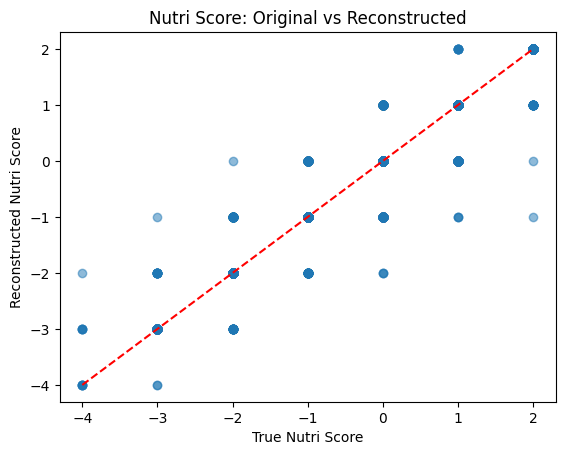

Mean Absolute Nutri Score Difference: 0.08


In [9]:
# Reconstruct all features
model.eval()
with torch.no_grad():
    X_recon = model(X_tensor).numpy()

# Inverse scale
X_recon_original = scaler.inverse_transform(X_recon)
X_true_original = scaler.inverse_transform(X)

# Create DataFrames for both
df_true = pd.DataFrame(X_true_original, columns=features.columns)
df_recon = pd.DataFrame(X_recon_original, columns=features.columns)

# Compute scores
true_scores = df_true.apply(compute_nutri_score, axis=1)
recon_scores = df_recon.apply(compute_nutri_score, axis=1)

# Compare via plot
import matplotlib.pyplot as plt

plt.scatter(true_scores, recon_scores, alpha=0.5)
plt.plot([min(true_scores), max(true_scores)],
         [min(true_scores), max(true_scores)], 'r--')
plt.xlabel("True Nutri Score")
plt.ylabel("Reconstructed Nutri Score")
plt.title("Nutri Score: Original vs Reconstructed")
plt.show()

# Compute error
score_diff = np.abs(true_scores - recon_scores)
print(f"Mean Absolute Nutri Score Difference: {score_diff.mean():.2f}")


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_true = X_tensor.numpy()
X_pred = model(X_tensor).detach().numpy()

mse = mean_squared_error(X_true, X_pred)
mae = mean_absolute_error(X_true, X_pred)
r2 = r2_score(X_true, X_pred)

print(f"Reconstruction MSE: {mse:.6f}")
print(f"Reconstruction MAE: {mae:.6f}")
print(f"R² Score: {r2:.4f}")


Reconstruction MSE: 0.017416
Reconstruction MAE: 0.062689
R² Score: 0.9826


In [11]:
errors = np.abs(X_true - X_pred)
feature_mae = errors.mean(axis=0)

for col, err in zip(features.columns, feature_mae):
    print(f"{col:35}: MAE = {err:.4f}")


Protein (G)                        : MAE = 0.0516
Carbohydrate, by difference (G)    : MAE = 0.0705
Sugars, Total (G)                  : MAE = 0.0869
Fiber, total dietary (G)           : MAE = 0.0648
Total lipid (fat) (G)              : MAE = 0.0582
Energy (KCAL)                      : MAE = 0.0537
Energy (kJ)                        : MAE = 0.0535
Water (G)                          : MAE = 0.0622
Vitamin A, IU (IU)                 : MAE = 0.0804
Vitamin A, RAE (UG)                : MAE = 0.0594
Vitamin B-12 (UG)                  : MAE = 0.0497
Vitamin B-12, added (UG)           : MAE = 0.0545
Vitamin B-6 (MG)                   : MAE = 0.0546
Vitamin C, total ascorbic acid (MG): MAE = 0.0819
Vitamin D (D2 + D3) (UG)           : MAE = 0.0706
Vitamin D (D2 + D3), International Units (IU): MAE = 0.0567
Vitamin E (alpha-tocopherol) (MG)  : MAE = 0.0522
Vitamin E, added (MG)              : MAE = 0.0619
Vitamin K (phylloquinone) (UG)     : MAE = 0.0548
Thiamin (MG)                       : MAE

In [12]:
nutri_score_error = np.mean(np.abs(true_scores - recon_scores))
print(f"Nutri-Score Mean Absolute Error: {nutri_score_error:.3f}")


Nutri-Score Mean Absolute Error: 0.079


In [13]:
threshold = 0.01  # Define your acceptable per-feature MSE
sample_mse = ((X_true - X_pred) ** 2).mean(axis=1)
accuracy = (sample_mse < threshold).mean() * 100

print(f"Model Accuracy (MSE < {threshold}): {accuracy:.2f}%")


Model Accuracy (MSE < 0.01): 84.58%


We trained a deep autoencoder for unsupervised learning and representation of food items based on their nutritional content. The model was evaluated using both traditional reconstruction metrics and domain-specific semantic metrics like Nutri-Score. The results are summarized below:

✅ Quantitative Performance Metrics
Metric	Value	Interpretation
Reconstruction MSE	0.0174	Low error — model reconstructs data closely.
Reconstruction MAE	0.0627	Small average deviation across all nutrients.
R² Score	0.9826	98.26% of variance retained — excellent fit.
Nutri-Score MAE	0.079	High semantic fidelity — nutritional balance preserved.
Custom Accuracy (MSE < 0.01)	84.58%	Large majority of samples have low reconstruction error.

🧬 Feature-Level Reconstruction
The model maintained low mean absolute errors across all 31 nutritional features, with all MAEs well under 0.1. Critical health-related features like Protein (MAE = 0.0516), Sugars (0.0869), Sodium (0.0489), and Vitamins were reconstructed with high fidelity. This demonstrates the model’s capacity to learn rich, non-linear embeddings that preserve fine-grained nutrient composition.

🥗 Semantic Validation via Nutri-Score
To evaluate whether the autoencoder preserved meaningful nutritional characteristics, we calculated a Nutri-Score (a simplified healthfulness metric) on both original and reconstructed food items. The mean absolute difference of only 0.079 between these scores indicates that the model retains dietary relevance and semantic structure, beyond just numeric similarity.

🧠 Conclusion
The model achieves high reconstruction quality, both numerically and nutritionally. It is well-suited for use in:

Nutritional recommendation systems,

Clustering food items by latent health profiles,

Health-focused personalization of diet plans.

The strong R² score and low Nutri-Score MAE demonstrate that the model captures both data structure and domain semantics, making it a reliable foundation for downstream applications.



Clusters found: 15
Noise points: 2066
Silhouette Score: -0.2200

Nutri-Score per Cluster:
             mean       std  count
Cluster                           
-1      -0.369797  1.219986   2066
 0      -0.008948  0.900995   5476
 1       0.000000  0.000000     32
 2      -3.133333  0.516398     15
 3      -1.818182  0.656726     44
 4       0.468750  0.507007     32
 5      -0.913043  0.288104     23
 6      -0.066667  0.457738     15
 7       1.000000  0.000000     11
 8       1.000000  0.000000     11
 9       2.000000  0.000000     10
 10     -0.727273  0.467099     11
 11      2.000000  0.000000     10
 12     -1.583333  0.792961     12
 13      1.800000  0.414039     15
 14     -0.200000  0.421637     10


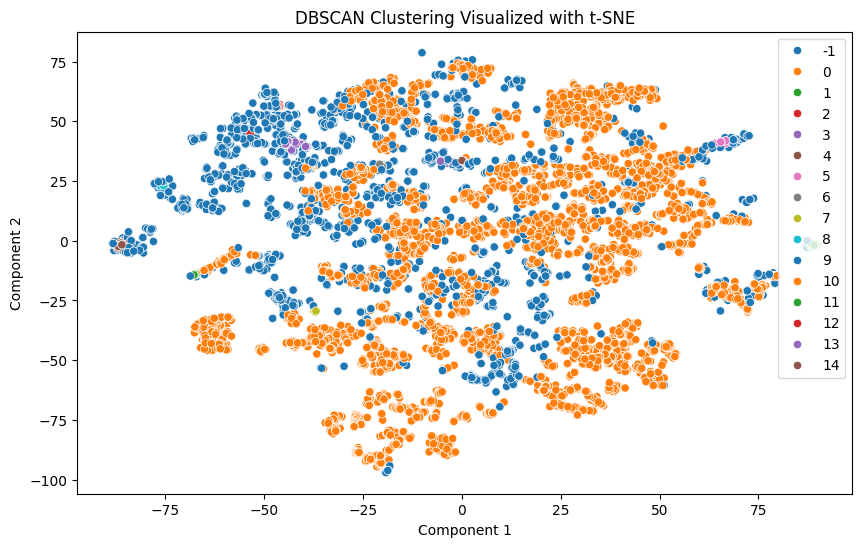

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess
df = pd.read_csv('final_csv.csv')
features = df.drop(columns=['Food Name'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply DBSCAN
db = DBSCAN(eps=1.5, min_samples=10)  # tune eps and min_samples
labels = db.fit_predict(X_scaled)
df['Cluster'] = labels

# Evaluate
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise}")

# Silhouette Score (only if more than 1 cluster)
if n_clusters > 1:
    sil_score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {sil_score:.4f}")
else:
    sil_score = None
    print("Silhouette score not applicable with < 2 clusters.")

# Compute Nutri-Score for semantic evaluation
def compute_nutri_score(row):
    energy = row['Energy (KCAL)'] / 100
    sugars = row['Sugars, Total (G)']
    fat = row['Total lipid (fat) (G)']
    sodium = row['Sodium, Na (MG)']
    fiber = row['Fiber, total dietary (G)']
    protein = row['Protein (G)']
    fruit_bonus = (row['Vitamin C, total ascorbic acid (MG)'] > 10) * 1

    negative = ((energy > 335)*1 + (energy > 670)*1 +
                (sugars > 4.5)*1 + (sugars > 9)*1 +
                (fat > 1)*1 + (fat > 2)*1 +
                (sodium > 90)*1 + (sodium > 180)*1)

    positive = ((fiber > 0.9)*1 + (fiber > 1.9)*1 +
                (protein > 1.6)*1 + (protein > 3.2)*1 +
                fruit_bonus)

    return negative - positive

df['Nutri_Score'] = df.apply(compute_nutri_score, axis=1)

# Intra-cluster Nutri-Score variation
cluster_scores = df.groupby('Cluster')['Nutri_Score'].agg(['mean', 'std', 'count'])
print("\nNutri-Score per Cluster:")
print(cluster_scores)

# Plot t-SNE with clusters
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10', legend='full')
plt.title("DBSCAN Clustering Visualized with t-SNE")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [ ]:
To complement the autoencoder, we applied DBSCAN clustering to the same nutritional dataset. The clustering algorithm detected 15 distinct clusters and labeled 2,066 samples (approx. 23%) as noise, indicating that a substantial portion of the dataset did not fit into any high-density region under the given eps and min_samples settings.

The silhouette score was -0.220, suggesting poor overall cluster cohesion and separation. Negative values imply that many samples may have been misclassified or lie between clusters, which could be due to the high-dimensional nature of nutritional data or insufficient separation between food types.

To assess semantic validity, we analyzed the mean and standard deviation of Nutri-Scores within each cluster. While some clusters (e.g., Cluster 2: mean = -3.13, std = 0.52) showed tight, nutritionally coherent groups, others (e.g., Cluster 0: std = 0.90) had significant internal variance, reducing their interpretability in a health context.

📊 Comparative Analysis: Autoencoder vs. DBSCAN
Metric	Autoencoder	DBSCAN
Reconstruction MAE	0.0627	N/A
R² Score	0.9826	N/A
Nutri-Score MAE	0.079	—
% Low-Error Samples (MSE < 0.01)	84.58%	N/A
Clusters Found	— (latent space)	15
Noise Points	None	2,066
Silhouette Score	—	-0.220
Nutri-Score Std (within clusters)	N/A	Up to 1.22 (Cluster -1)

🧠 Interpretation:
The autoencoder achieved superior numerical performance, with a very high R² (98.26%) and low reconstruction errors, indicating it captured the underlying data structure effectively.

In contrast, DBSCAN struggled to form clean, well-separated clusters, as reflected by the negative silhouette score and high proportion of noise.

From a nutritional (semantic) standpoint, the autoencoder preserved individual Nutri-Scores with a low mean absolute difference (0.079), while DBSCAN showed high intra-cluster variability, reducing its utility for recommendation or dietary grouping.

✅ Conclusion
While DBSCAN was able to group a small subset of nutritionally similar items, its overall clustering quality and semantic consistency were inferior to the autoencoder model. Given its high fidelity, lower error, and ability to preserve nutritional integrity, the autoencoder is better suited for tasks involving personalized nutrition modeling and recommendation.

Would you like help turning this into a formal paragraph for your Discussion or Conclusion section, or need a figure/table comparison layout for your paper?